We illustrate empirical calibration on Kang-Schafer simulation under both correctly specified and misspecified models, and benchmark the execution time.

In [0]:
#@title Copyright 2019 The Empirical Calibration Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/empirical_calibration/blob/master/notebooks/kang_schafer_population_mean.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/empirical_calibration/blob/master/notebooks/kang_schafer_population_mean.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

>>[Simulation](#scrollTo=UcGow9kNJsrl)

>>[Imports](#scrollTo=VGDMBD7TRIf4)

>>[Selection Bias](#scrollTo=D8orhXBdZq9l)

>>[Correctly Specified Model](#scrollTo=X1D4OBiEZhnT)

>>[Misspecified Model](#scrollTo=0zuCvTGVdMVj)

>>[Adding transformations of covariates](#scrollTo=y4uYEPCnoUzG)

>>[Adding extra covariates](#scrollTo=1Ji6iROgDYfv)

>>[Benchmark Execution Time](#scrollTo=ITCnSqDiyjIx)



## Simulation
The true set of covariates is generated independently and identically
distributed from the standard normal distribution
$$
(Z_1, Z_2, Z_3, Z_4) \sim N(0, \mathbf{I}_4).
$$

The outcome is generated as
$$
Y = 210 + 27.4 Z_1 + 13.7 Z_2 + 13.7 Z_3 + 13.7 Z_4 + \epsilon,
$$
where $\epsilon \sim N(0, 1)$.


The propensity score is defined as
$$
Pr(T = 1 | Z) = \text{expit}(-Z_1 + 0.5 Z_2 - 0.25 Z_3 - 0.1 Z_4),
$$
where $\text{expit}(x) = 1/(1+\text{exp}(-x)).$

This mechanism produces an equal-sized treated and control group
on average. Given the covariates, the outcome is independent of the treatment
assignment, thus the true ATT is zero. The overall outcome mean is 210. Due to
the treatment selection bias, the outcome mean for the treated group (200) is
lower than that of the control group (220).

The typical exercise is to examine the performance of an observational method
under both correctly specified and misspecified propensity score and/or outcome
regression models. Misspecification occurs when the following nonlinear
transformation $X_i$'s are observed in place of the true covariates

\begin{align*}
X_{i1} & = \exp(Z_{i1}/2), \\
X_{i2} & = Z_{i2} / (1 + \exp(Z_{i1})) + 10, \\
X_{i3} & = (Z_{i1} Z_{i3} / 25 + 0.6)^3, \\
X_{i4} & = (Z_{i2} + Z_{i4} + 20)^2.
\end{align*}

For more context, see [paper](www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf).

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'

from google.colab import widgets

# install and import ec
!pip install -q git+https://github.com/google/empirical_calibration
import empirical_calibration as ec


## Selection Bias

We first simulate one dataset of size $2000$ to examine the selection bias.

In [0]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=2000)

In [0]:
df = pd.DataFrame(
    np.column_stack([
        simulation.treatment, simulation.covariates,
        simulation.transformed_covariates, simulation.outcome
    ]))
df.columns = [
    "treatment", "z1", "z2", "z3", "z4", "x1", "x2", "x3", "x4", "outcome"
]

The treated group has a lower outcome mean than that of the control group, but the difference is not necessarily attributed to the causal effect of the treatment.

In [6]:
print(df.groupby("treatment").mean().T)

treatment         0.0         1.0
z1           0.383066   -0.403063
z2          -0.189319    0.244439
z3           0.134996   -0.114127
z4           0.017339   -0.018848
x1           1.339729    0.907298
x2           9.897616   10.123162
x3           0.220736    0.220331
x4         395.051555  410.947713
outcome    219.997301  200.567004


The distributions of covariates or transformed covariates don't completely overlap between the treated and control groups.

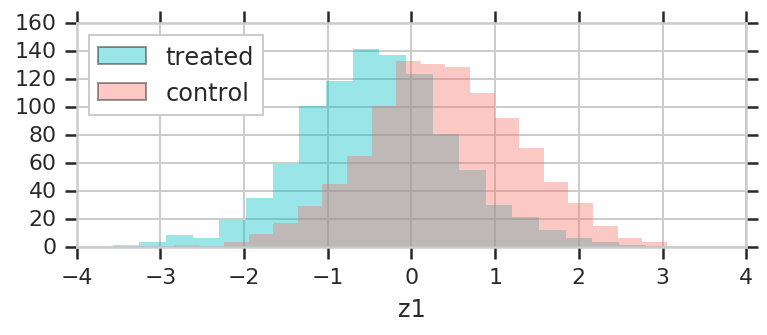

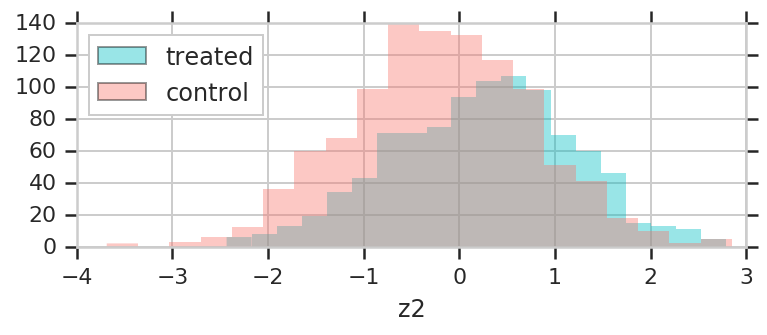

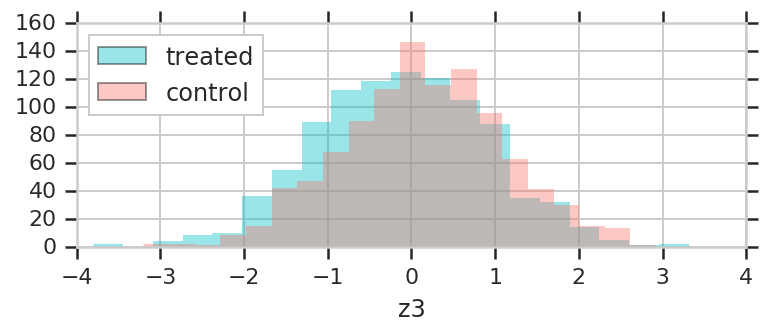

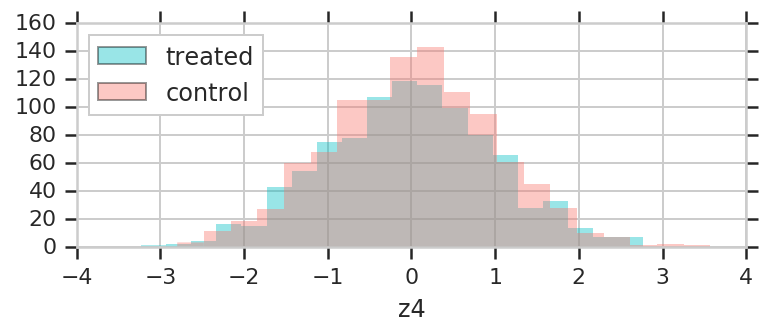

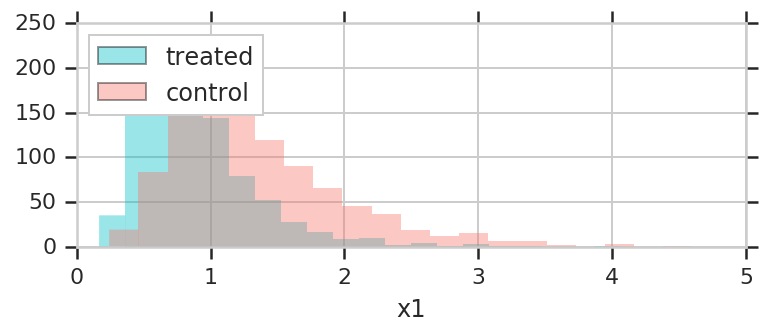

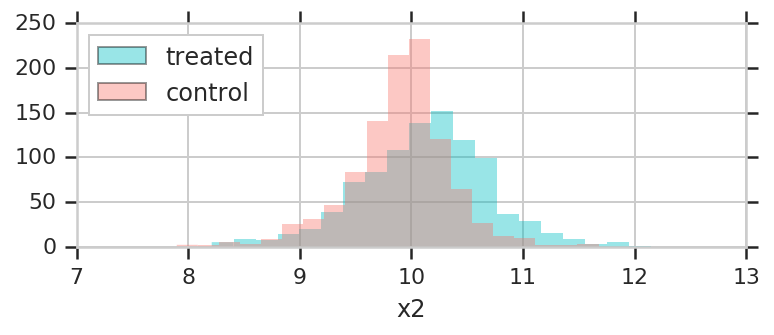

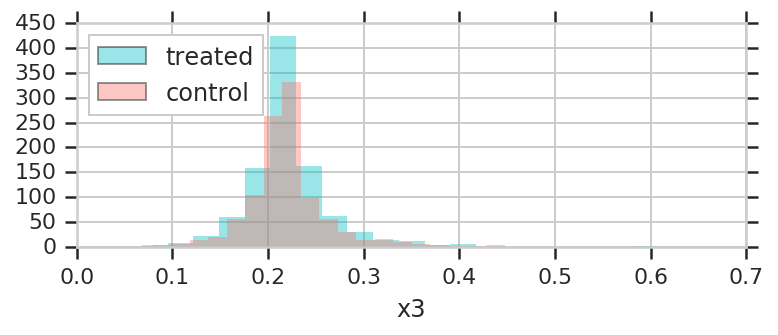

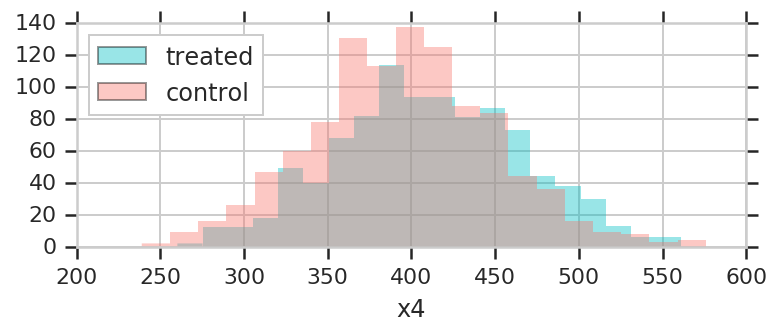

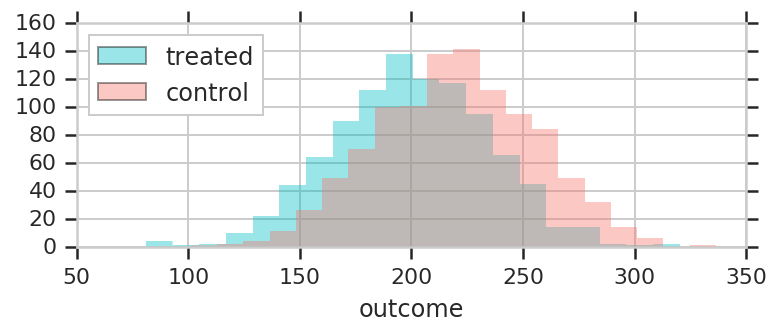

In [10]:
def show_hist(name):
  plt.figure(figsize=(6, 2))
  plt.hist(
      df.loc[df['treatment'] == 1, name],
      bins=20,
      alpha=0.4,
      color='#00BFC4',
      label='treated',
      edgecolor='none')
  plt.hist(
      df.loc[df['treatment'] == 0, name],
      bins=20,
      alpha=0.4,
      color='#F8766D',
      label='control',
      edgecolor='none')
  plt.xlabel(name)
  plt.legend(loc='upper left', prop={'size': 12})
  plt.show()

tb = widgets.TabBar(['covariates', 'transformed_covariates', 'outcome'])
with tb.output_to('covariates'):
  for name in ["z1", "z2", "z3", "z4"]:
    show_hist(name)

with tb.output_to('transformed_covariates'):
  for name in ["x1", "x2", "x3", "x4"]:
    show_hist(name)

with tb.output_to('outcome'):
  show_hist("outcome")

## Correctly Specified Model

We run the simulation $1000$ times under correctly specified logistic propensity score. For each simulation, the treatment group was weighted so that it matches the population in terms of their covariate distributions.
The estimator is the weighted value of $y$ in the treatment group.

In [0]:
def estimate_mean(formula):
  simulation = ec.data.kang_schafer.Simulation(size=1000)

  t = simulation.treatment
  y = simulation.outcome

  df = pd.DataFrame(
      np.column_stack(
          [simulation.covariates, simulation.transformed_covariates]))
  df.columns = ["z1", "z2", "z3", "z4", "x1", "x2", "x3", "x4"]
  x = patsy.dmatrix(formula, df, return_type="dataframe").values

  weights = ec.from_formula(formula=formula,
                            df=df.loc[t==1],
                            target_df=df)[0]

  return np.mean(np.sum(y[t == 1] * weights))

def show_estimates(estimates):
  estimates = pd.Series(estimates)
  ax = estimates.hist(bins=20, alpha=0.8, edgecolor='none')
  plt.axvline(estimates.mean(), linestyle='dashed', color='red')
  # True population mean is 210.
  print('bias is {}'.format(estimates.mean() - 210.))
  print('rmse is {}'.format(np.sqrt(np.mean((estimates - 210.) ** 2))))

estimates_correct = [estimate_mean("-1 + z1 + z2 + z3 + z4") for i in xrange(1000)]

With correctly specified covariates to match ($Z1, \dots, Z4$),
the bias is smaller and the RMSE is better than any of the methods in the Kang & Schafer paper, where the best RMSE was 1.17.

bias is 0.0350477677586
rmse is 1.13484576048


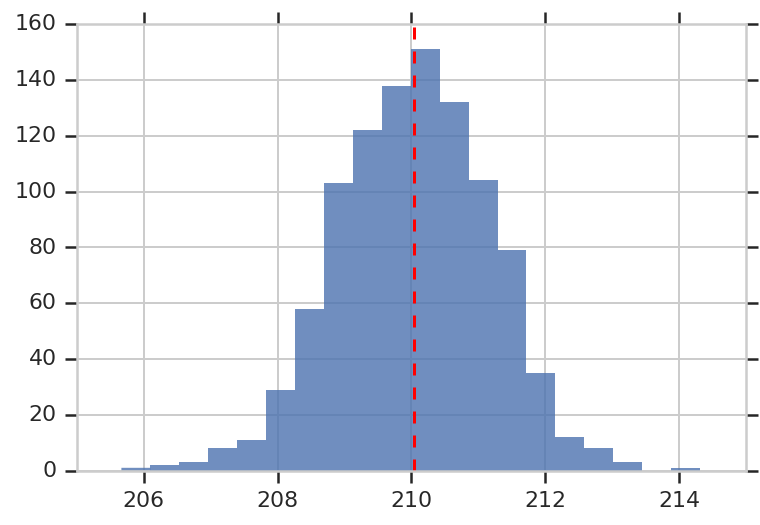

In [21]:
show_estimates(estimates_correct)

## Misspecified Model

If the transformed covariates are observed in place of the true covariates, aka the propensity score model is misspecified, the estimate is no long un-biased.

In [0]:
estimates_miss = [estimate_mean("-1 + x1 + x2 + x3 + x4") for i in xrange(1000)]

bias is -1.96987818018
rmse is 2.48825392824


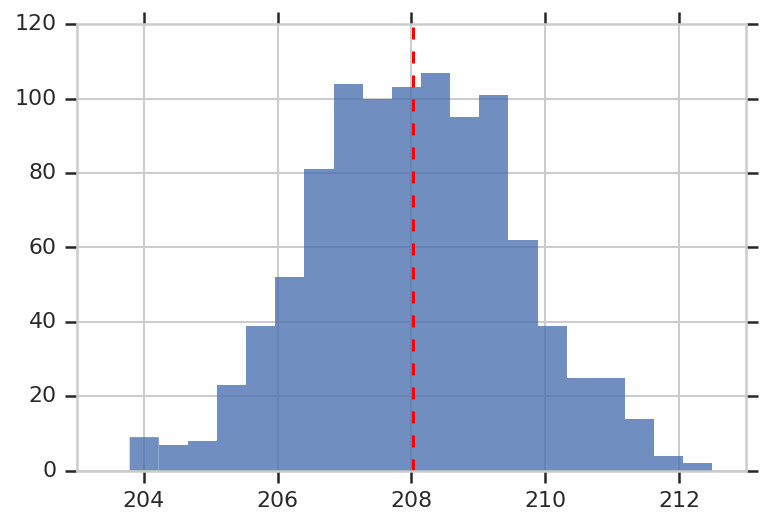

In [23]:
show_estimates(estimates_miss)

## Adding transformations of covariates

One reasonable strategy is to expand the set of balancing covariates and hope it will make the model less "misspecified". If we additional balance the two-way interactions and the log transformation, the bias indeed reduces.

In [0]:
formula = ("-1 + (x1 + x2 + x3 + x4)**2 + I(np.log(x1)) + I(np.log(x2)) + "
           "I(np.log(x3)) + I(np.log(x4))")
estimates_expanded = [estimate_mean(formula) for i in xrange(1000)]

bias is -0.84544280528
rmse is 1.59210353659


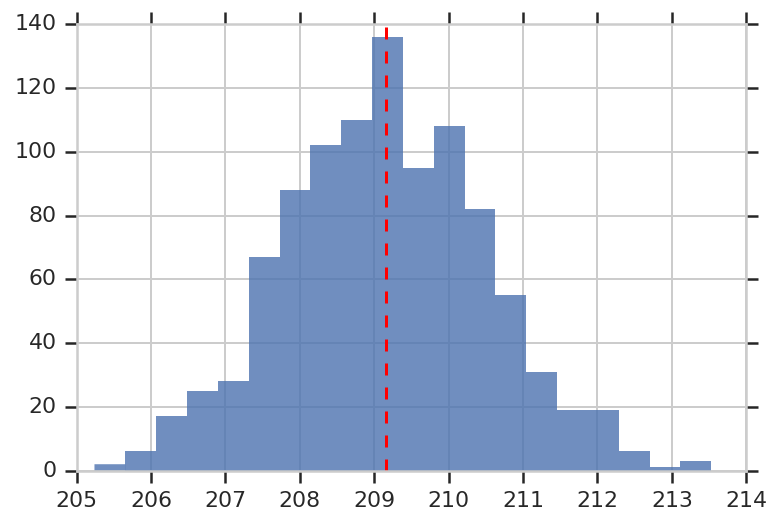

In [25]:
show_estimates(estimates_expanded)

## Adding extra covariates
If the model is misspecified in the sense that more covariates are included than necessary, the causal estimate remains unbiased.

In [0]:
formula = "-1 + z1 + z2 + z3 + z4 + x1 + x2 + x3 + x4"
estimates_redundant = [estimate_mean(formula) for i in xrange(1000)]

bias is -0.0523106606256
rmse is 1.10923646003


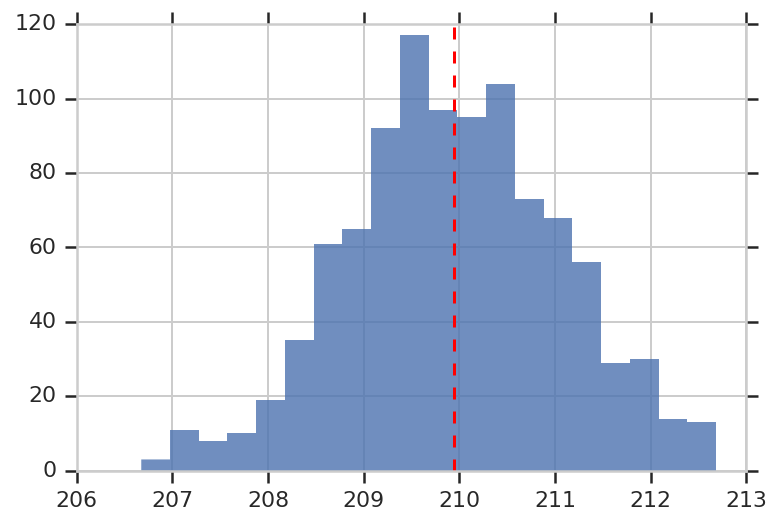

In [27]:
show_estimates(estimates_redundant)

## Benchmark Execution Time

The execution time is generally linear with respect to the sample size.

In [0]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=2000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
%timeit weights = ec.maybe_exact_calibrate(x0, x1)[0]

1000 loops, best of 3: 1.42 ms per loop


In [0]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=20000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
%timeit weights = ec.maybe_exact_calibrate(x0, x1)[0]

100 loops, best of 3: 9.51 ms per loop


In [0]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=200000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
%timeit weights = ec.maybe_exact_calibrate(x0, x1)[0]

10 loops, best of 3: 103 ms per loop


In [0]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=2000000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
%timeit weights = ec.maybe_exact_calibrate(x0, x1)[0]

1 loops, best of 3: 1.42 s per loop
